# Text Classification

In [1]:
import itertools
import re

from dataset import news20
from nn.layer import *
from nn.criterion import *
from optim.optimizer import *
from util.common import *
from util.common import Sample

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import pandas as pd
from wordcloud import WordCloud
import random as rd
import datetime as dt

init_engine()

## 1. Define some utility functions

In [2]:
# break the text corpus into tokens (words)
def text_to_words(review_text):
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    return words

# calcualte the frequency of words in each text corpus, sort by frequency, and assign an id to each word
def analyze_texts(data_rdd):
    return data_rdd.flatMap(lambda (text, label): text_to_words(text)) \
        .map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b) \
        .sortBy(lambda (w, c): - c).zipWithIndex() \
        .map(lambda ((w, c), i): (w, (i + 1, c))).collect()

# pad the embedding to required length
# pad([1, 2, 3, 4, 5], 0, 6)
def pad(l, fill_value, width):
    if len(l) >= width:
        return l[0: width]
    else:
        l.extend([fill_value] * (width - len(l)))
        return l

# word to vec
def to_vec(token, b_w2v, embedding_dim):
    if token in b_w2v:
        return b_w2v[token]
    else:
        return pad([], 0, embedding_dim)

# assemble the features (embeddings of words in each text sample) and label into samples
def to_sample(vectors, label, embedding_dim,sequence_len):
    # flatten nested list
    flatten_features = list(itertools.chain(*vectors))
    features = np.array(flatten_features, dtype='float').reshape(
        [sequence_len, embedding_dim]).transpose(1, 0)
    return Sample.from_ndarray(features, np.array(label))

## 2. Training the model

* set some tunable parameters

In [3]:
batch_size = 128
embedding_dim = 50
sequence_len = 50
max_words = 1000 
training_split = 0.8

* prepare samples

In [4]:
! ls -lh /tmp/news20

total 823M
drwxrwxr-x. 2 linux linux 4.0K Mar 21 15:06 glove.6B
-rw-------. 1 linux linux 823M Mar 21 15:05 glove.6B.zip


In [5]:
#analyze input texts and prepare data_rdd
texts = news20.get_news20('../../data/news20data')
data_rdd = sc.parallelize(texts, 2)
word_to_ic = analyze_texts(data_rdd)
# take the top "max_words" most frequent words while remove the top 10 ( may not be meaningful,e.g. "of","the")
word_to_ic = dict(word_to_ic[10: max_words])
bword_to_ic = sc.broadcast(word_to_ic)

Found 19997 texts.


In [6]:
def prepare_samples(data_rdd=data_rdd,
                    sequence_len=sequence_len,
                    embedding_dim=embedding_dim):
    print "preparing samples with embedding_dim = %s, sequence_len=%s"%(embedding_dim,sequence_len)

    #prepare embeddings
    w2v = news20.get_glove_w2v(dim=embedding_dim)
    filtered_w2v = {w: v for w, v in w2v.items() if w in word_to_ic}
    bfiltered_w2v = sc.broadcast(filtered_w2v)

    tokens_rdd = data_rdd.map(lambda (text, label):
                              ([w for w in text_to_words(text) if
                                w in bword_to_ic.value], label))
    padded_tokens_rdd = tokens_rdd.map(
        lambda (tokens, label): (pad(tokens, "##", sequence_len), label))

    vector_rdd = padded_tokens_rdd.map(lambda (tokens, label):
                                       ([to_vec(w, bfiltered_w2v.value,
                                                embedding_dim) for w in
                                         tokens], label))
    sample_rdd = vector_rdd.map(
        lambda (vectors, label): to_sample(vectors, label, embedding_dim,sequence_len))
    print('Generated Samples')
    return sample_rdd


sample_rdd = prepare_samples()

preparing samples with embedding_dim = 50, sequence_len=50
Generated Samples


* pick a random text and draw a word cloud to gain some sense into what the new sample is about. 

(-0.5, 399.5, 199.5, -0.5)

/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


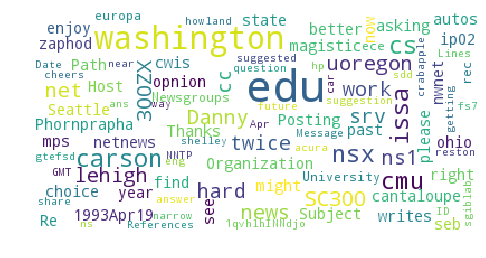

In [7]:
rand_idx=rd.randrange(0, len(texts))
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(texts[rand_idx][0])

plt.imshow(wordcloud)
plt.axis("off")

* split the samples into train and validation set 

In [8]:
#split train val sets
train_rdd, val_rdd = sample_rdd.randomSplit([training_split, 1-training_split])

* build the model

In [9]:
def build_model(class_num=news20.CLASS_NUM,
                embedding_dim=embedding_dim,
                sequence_len=sequence_len):
    print "building model with embedding_dim = %s, sequence_len=%s"%(embedding_dim,sequence_len)
    model = Sequential()
    model.add(Reshape([embedding_dim, 1, sequence_len]))
    model.add(SpatialConvolution(embedding_dim, 128, 5, 1).set_name('conv1'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(SpatialConvolution(128, 128, 5, 1).set_name('conv2'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(Reshape([128]))
    model.add(Linear(128, 100).set_name('fc1'))
    model.add(Linear(100, class_num).set_name('fc2'))
    model.add(LogSoftMax())
    return model

model = build_model()

building model with embedding_dim = 50, sequence_len=50
creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createLinear
creating: createLogSoftMax


* configure optimizer

In [10]:
from nn.criterion import *
#configure optimizer
def create_optimizer(model,
                     app_name,
                     logdir='/tmp/bigdl_summaries',
                     batch_size=batch_size,
                     lr=0.01,
                     lrd=0.0002,
                     optim="Adagrad",
                     val=["Top1Accuracy"],
                     max_epoch=2):
    print "optimize summary will be write to :",logdir+'/'+app_name
    state = {"batchSize": batch_size,
         "learningRate": lr,
         "learningRateDecay": lrd}
    #configure optimizer
    optimizer = Optimizer(
        model=model,
        training_rdd=train_rdd,
        criterion=ClassNLLCriterion(),
        end_trigger=MaxEpoch(max_epoch),
        batch_size=batch_size,
        optim_method=optim,
        state=state)

    optimizer.setvalidation(
        batch_size=batch_size,
        val_rdd=val_rdd,
        trigger=EveryEpoch(),
        val_method=val
    )
    train_summary = TrainSummary(log_dir=logdir, app_name=app_name)
    train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
    val_summary = ValidationSummary(log_dir=logdir, app_name=app_name)
    optimizer.set_train_summary(train_summary)
    optimizer.set_val_summary(val_summary)
    return optimizer,train_summary,val_summary

optimizer,train_summary1,val_summary1 = create_optimizer(model,'adagrad-'+ dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
print "done"

optimize summary will be write to : /tmp/bigdl_summaries/adagrad-20170323-050532
creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
done


* Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [11]:
%%time
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 5.58 ms, sys: 295 µs, total: 5.87 ms
Wall time: 26.3 s


## 3. Examine the prediction results

* Let's look closely on the predicted results of validation set

In [12]:
predictions = trained_model.predict(val_rdd)

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

y_pred = np.array([ map_predict_label(s.label) for s in predictions.collect()])

y_true = np.array([map_groundtruth_label(s.label) for s in val_rdd.collect()])

* compute the confustion matrix and plot it

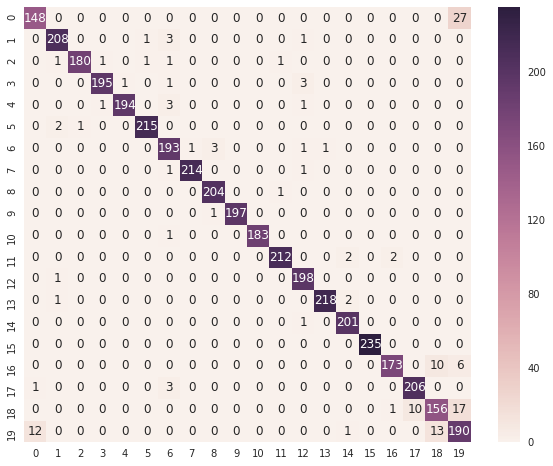

In [13]:
cm = confusion_matrix(y_true, y_pred)
cm.shape

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d')

## 4 Change optimization methods

* create a new optimizer and use SGD as optim_method, train a new model and make predictions. The confusion matrix shows the result is much worse than Adagrad after 2 epochs. SGD needs much longer to converge than Adagrad. 

In [14]:
%%time
#need to build a new model, because after optimization, the input model is modified *in-place*. 
#use model without building a new one equals to resume training based on the trained model in the previous step
model = build_model()
optimizer,train_summary2,val_summary2  = create_optimizer(model,
                                                          app_name='sgd-'+ dt.datetime.now().strftime("%Y%m%d-%H%M%S"),
                                                          optim="SGD")
print "done"

building model with embedding_dim = 50, sequence_len=50
creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createLinear
creating: createLogSoftMax
optimize summary will be write to : /tmp/bigdl_summaries/sgd-20170323-050734
creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
done
CPU times: user 48.7 ms, sys: 3.62 ms, total: 52.3 ms
Wall time: 36.7 s


In [15]:
%%time
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 4.64 ms, sys: 226 µs, total: 4.87 ms
Wall time: 20.3 s


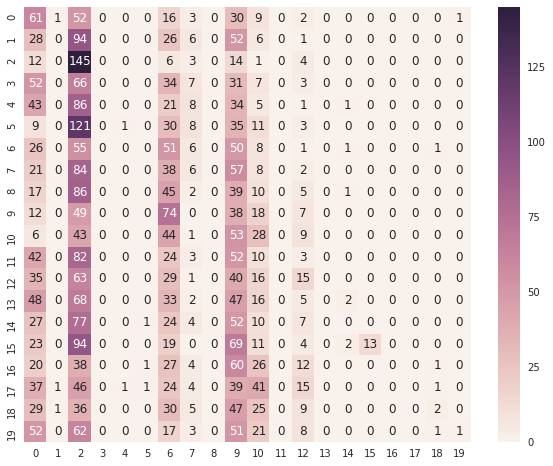

In [16]:
predictions = trained_model.predict(val_rdd)
y_pred2 = np.array([ map_predict_label(s.label) for s in predictions.collect()])

plt.figure(figsize = (10,8))
sn.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred2)), annot=True,fmt='d')

(array([  603.,  1447.,     5.,   688.,   890.,   287.,   116.,    20.,
            0.,     8.]),
 array([  0. ,   1.9,   3.8,   5.7,   7.6,   9.5,  11.4,  13.3,  15.2,
         17.1,  19. ]),
 <a list of 10 Patch objects>)

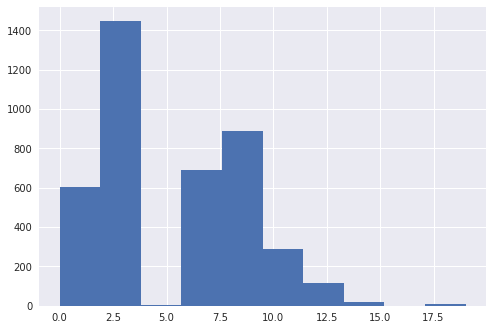

In [17]:
plt.hist(y_pred2)

(array([ 388.,  385.,  417.,  415.,  403.,  400.,  420.,  437.,  399.,  400.]),
 array([  0. ,   1.9,   3.8,   5.7,   7.6,   9.5,  11.4,  13.3,  15.2,
         17.1,  19. ]),
 <a list of 10 Patch objects>)

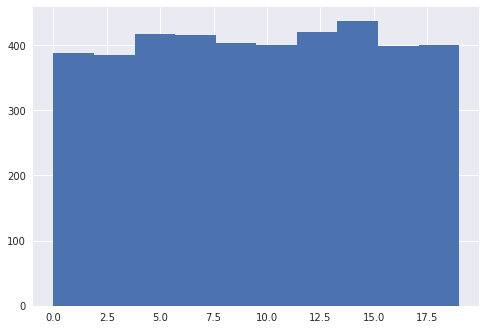

In [18]:
plt.hist(y_true)

## 5. Plot the learning curves

* training loss

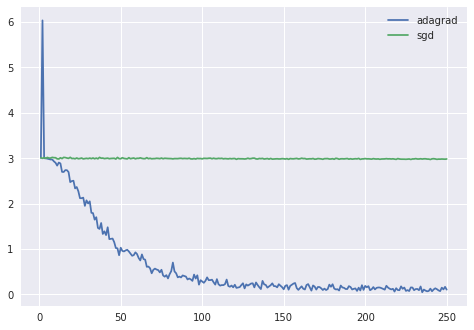

In [21]:
loss_adagrad = np.array(train_summary1.read_scalar("Loss"))
loss_sgd = np.array(train_summary2.read_scalar("Loss"))
# each event data has 3-dimension value, in the form of (iteration_count, value, timestamp)
loss_adagrad.shape,loss_sgd.shape

plt.plot(loss_adagrad[:,0],loss_adagrad[:,1],label='adagrad')
plt.plot(loss_sgd[:,0],loss_sgd[:,1],label='sgd')
plt.legend()

* validation top1 accuracy

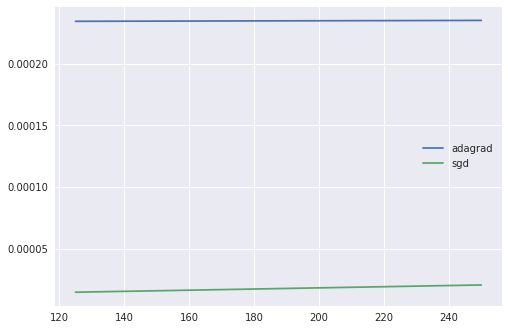

In [23]:
top1_adagrad = np.array(val_summary1.read_scalar("Top1Accuracy"))
top1_sgd = np.array(val_summary2.read_scalar("Top1Accuracy"))
top1_adagrad.shape,top1_sgd.shape

plt.plot(top1_adagrad[:,0],top1_adagrad[:,1],label='adagrad')
plt.plot(top1_sgd[:,0],top1_sgd[:,1],label='sgd')
plt.legend()

* Throughput

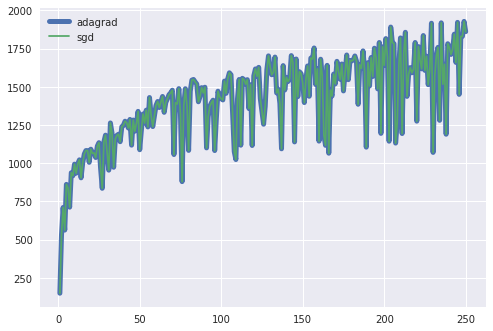

In [25]:

tp_adagrad = np.array(train_summary1.read_scalar("Throughput"))
tp_sgd = np.array(train_summary2.read_scalar("Throughput"))
# each event data has 3-dimension value, in the form of (iteration_count, value, timestamp)
tp_adagrad.shape,tp_sgd.shape

plt.plot(tp_adagrad[:,0],tp_adagrad[:,1],label='adagrad',linewidth=5)
plt.plot(tp_adagrad[:,0],tp_adagrad[:,1],label='sgd')
plt.legend()